In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from google.colab import drive


**Import Data**

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset = pd.read_csv("/content/drive/My Drive/STLF_DATASET/dataset.csv")
dataset.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0


**Data normalization and cleaning**

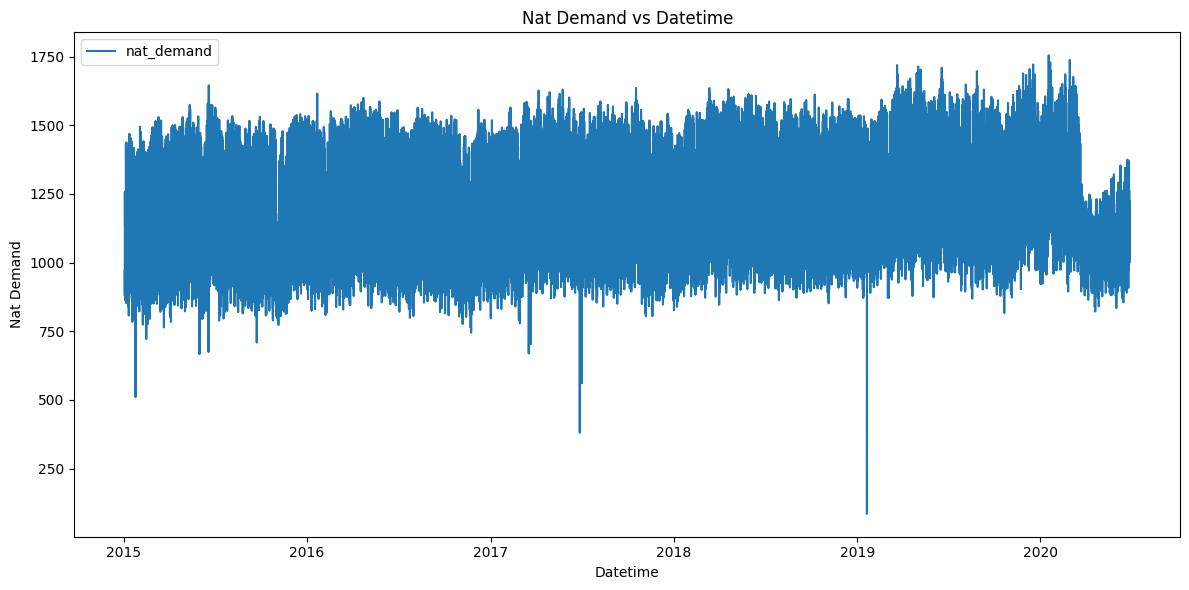

In [ ]:
dataset['datetime'] = pd.to_datetime(dataset['datetime'])
plt.figure(figsize=(12, 6))
plt.plot(dataset['datetime'], dataset['nat_demand'], label='nat_demand')
plt.xlabel('Datetime')
plt.ylabel('Nat Demand')
plt.title('Nat Demand vs Datetime')
plt.legend()
plt.tight_layout()
plt.show()


MinMax scaling

In [ ]:
features = [col for col in dataset.columns if col not in ['datetime','Holiday_ID']]

scaler  = MinMaxScaler()
dataset[features] = scaler.fit_transform(dataset[features])
dataset.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,0.530130,0.240921,0.613218,0.031030,0.556888,0.192620,0.589439,0.003807,0.420437,0.191031,0.605293,0.201083,0.520631,0,0.0,0.0
1,2015-01-03 02:00:00,0.495291,0.243734,0.620449,0.031499,0.564955,0.188309,0.588850,0.002718,0.434872,0.185206,0.600666,0.183389,0.540909,0,0.0,0.0
2,2015-01-03 03:00:00,0.488160,0.246880,0.631220,0.029698,0.572297,0.185422,0.584380,0.002926,0.442791,0.181852,0.598003,0.164737,0.569985,0,0.0,0.0
3,2015-01-03 04:00:00,0.481983,0.248557,0.642709,0.031221,0.563516,0.179994,0.577349,0.005340,0.428203,0.180535,0.598683,0.143082,0.571196,0,0.0,0.0
4,2015-01-03 05:00:00,0.484218,0.249905,0.651273,0.033153,0.539947,0.171528,0.571549,0.003547,0.396060,0.178394,0.595968,0.134650,0.544729,0,0.0,0.0


**Hampel identifier to fill in missing Values**              

In [ ]:
#function for hampel Identifier|
def hampel_filter(series, window_size=7, n_sigmas=3):
    """
    Apply Hampel filter to a Pandas Series to detect and replace outliers.

    Args:
        series (pd.Series): Time series data
        window_size (int): Size of the sliding window (must be odd)
        n_sigmas (float): Threshold in terms of scaled MAD

    Returns:
        pd.Series: Series with outliers replaced by median
    """
    n = len(series)
    new_series = series.copy()
    k = 1.4826  # scaling factor for MAD → std

    for i in range(window_size, n - window_size):
        window = series[(i - window_size):(i + window_size)]
        median = window.median()
        mad = k * np.median(np.abs(window - median))

        if np.abs(series[i] - median) > n_sigmas * mad:
            new_series[i] = median  # replace outlier with median

    return new_series


In [ ]:
columns_to_filter = [col for col in dataset.columns if col not in [  "datetime" ,"Holiday_ID","school","holiday"]]
print(columns_to_filter)

for col in columns_to_filter:
    dataset[col] = hampel_filter(dataset[col], window_size=7, n_sigmas=3)


['nat_demand', 'T2M_toc', 'QV2M_toc', 'TQL_toc', 'W2M_toc', 'T2M_san', 'QV2M_san', 'TQL_san', 'W2M_san', 'T2M_dav', 'QV2M_dav', 'TQL_dav', 'W2M_dav']


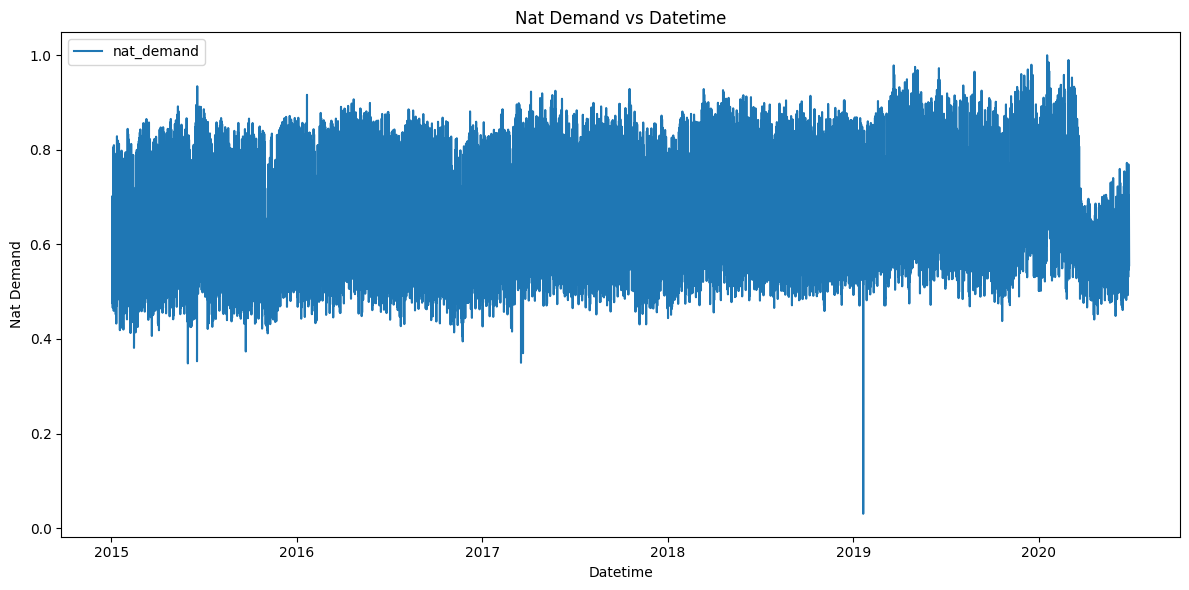

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(dataset['datetime'], dataset['nat_demand'], label='nat_demand')
plt.xlabel('Datetime')
plt.ylabel('Nat Demand')
plt.title('Nat Demand vs Datetime')
plt.legend()
plt.tight_layout()
plt.show()


 **stationarity and perform differencing if necessary**






In [ ]:
# Suppose 'load' is your load demand column
# and 'df' is your dataset with datetime index
series = dataset['nat_demand']
#Train-test split
train_size = int(len(series) * 0.65)
train, test = series[:train_size], series[train_size:]

In [ ]:
#check for stationarity for the train
result = adfuller(train)
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:")
for key, value in result[4].items():
    print(f"\t{key}: {value}")

ADF Statistic: -20.714999204134745
p-value: 0.0
Critical Values:
	1%: -3.430559751385769
	5%: -2.8616327045715937
	10%: -2.5668193437920617


In [ ]:
# the data is stationary

In [ ]:
train_diff = train.diff().dropna()

Determining ARIMA parameters

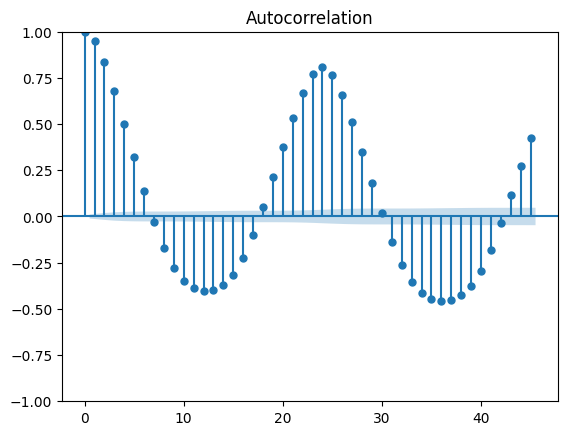

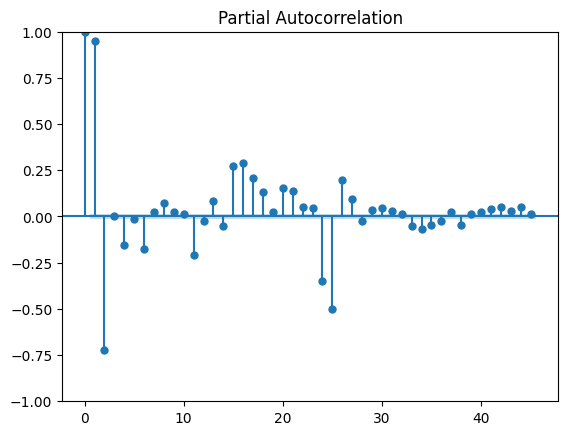

In [ ]:
plot_acf(train)
plt.show()

plot_pacf(train)
plt.show()

### Fitting the ARIMA model

In [ ]:
model = ARIMA(train , order=(0,1,0))
model_fit  = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             nat_demand   No. Observations:                31231
Model:                 ARIMA(0, 1, 0)   Log Likelihood               59283.384
Date:                Tue, 02 Sep 2025   AIC                        -118564.767
Time:                        10:18:27   BIC                        -118556.418
Sample:                             0   HQIC                       -118562.093
                              - 31231                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0013   7.87e-06    167.048      0.000       0.001       0.001
Ljung-Box (L1) (Q):               14348.40   Jarque-Bera (JB):              7354.20
Prob(Q):                              0.00   Pr

# Forecasting

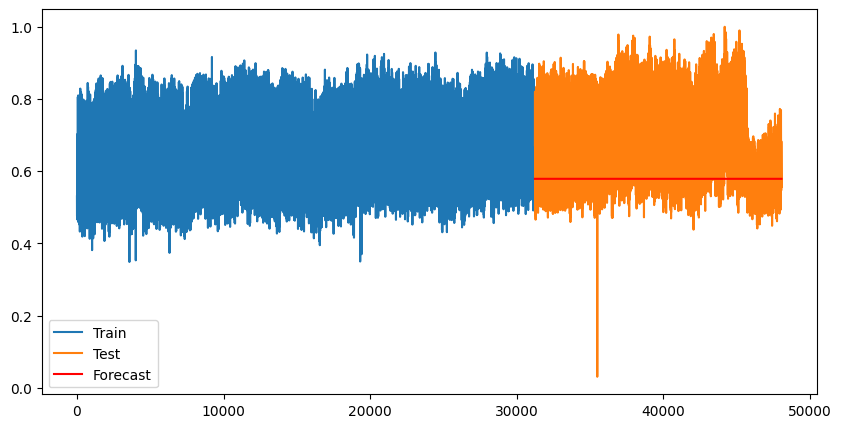

In [ ]:
# Forecast the same length as test
forecast = model_fit.forecast(steps=len(test))

# Plot prediction vs real
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.show()


# Evalutation

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(test, forecast)
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mse)

print(f'MSE: {mse}, RMSE: {rmse}, MAE: {mae}')


MSE: 0.013010371657445187, RMSE: 0.11406301616845482, MAE: 0.09711159514667925


# Inverse Transform

In [ ]:
dataset[features] = scaler.inverse_transform(dataset[features])
dataset.head()

,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0.0,0.0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0.0,0.0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0.0,0.0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0.0,0.0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0.0,0.0


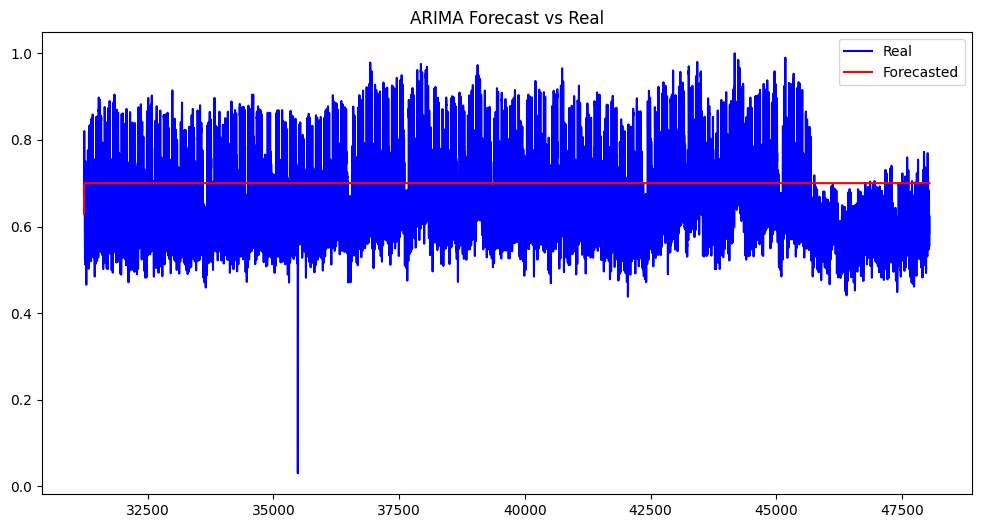

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test.index, test, label='Real', color='blue')
plt.plot(test.index, forecast, label='Forecasted', color='red')
plt.legend()
plt.title("ARIMA Forecast vs Real")
plt.show()


,datetime,nat_demand,T2M_toc,QV2M_toc,TQL_toc,W2M_toc,T2M_san,QV2M_san,TQL_san,W2M_san,T2M_dav,QV2M_dav,TQL_dav,W2M_dav,Holiday_ID,holiday,school
0,2015-01-03 01:00:00,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0.0,0.0
1,2015-01-03 02:00:00,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0.0,0.0
2,2015-01-03 03:00:00,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0.0,0.0
3,2015-01-03 04:00:00,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0.0,0.0
4,2015-01-03 05:00:00,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0.0,0.0


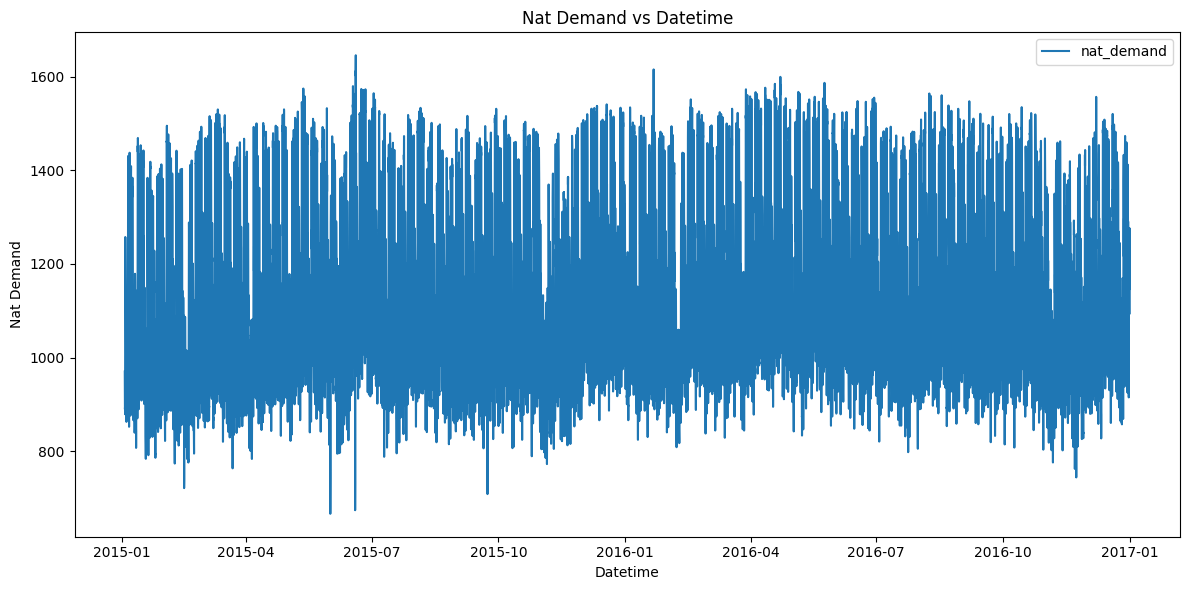

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['nat_demand'], label='nat_demand')
plt.xlabel('Datetime')
plt.ylabel('Nat Demand')
plt.title('Nat Demand vs Datetime')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

# --- Prepare series and train/test split ---
# assume `df` already contains the subset 2015-2016 and has columns:
# 'datetime' (datetime dtype), 'nat_demand' (target),
# and optional exogenous columns like 'temperature'
df  = dataset(dataset['datetime'].dt.year.between(2015, 2016))
series = df.set_index('datetime')['nat_demand'].asfreq('H')  # ensure hourly index
# if there are missing timestamps, consider series = series.interpolate() or .ffill()

train_size = int(len(series) * 0.8)
train, test = series.iloc[:train_size], series.iloc[train_size:]

# --- Optional: exogenous variables ---
# If you want to include temperature/humidity/etc, uncomment and adapt the following:
use_exog = True   # set False to skip exogenous variables
if use_exog:
    exog_cols = ['temperature']  # list the exogenous columns you want
    exog = df.set_index('datetime')[exog_cols].asfreq('H')
    exog_train, exog_test = exog.iloc[:train_size], exog.iloc[train_size:]
else:
    exog_train = exog_test = None

# --- auto_arima to select best (p,d,q) and seasonal (P,D,Q,m) ---
# m=24 because hourly data with daily seasonality
stepwise_model = auto_arima(
    train,
    exogenous=exog_train if use_exog else None,
    seasonal=True,
    m=24,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    max_p=5, max_q=5, max_P=2, max_Q=2  # adjust search bounds to taste
)

print("Auto-ARIMA summary:")
print(stepwise_model.summary())

best_order = stepwise_model.order
best_seasonal_order = stepwise_model.seasonal_order
print("Selected order:", best_order)
print("Selected seasonal_order:", best_seasonal_order)

# --- Fit SARIMAX (use statsmodels for in-sample diagnostics and forecasting) ---
model = SARIMAX(
    train,
    exog=exog_train if use_exog else None,
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
model_fit = model.fit(disp=False)
print(model_fit.summary())

# --- Forecast ---
n_steps = len(test)
if use_exog:
    forecast = model_fit.forecast(steps=n_steps, exog=exog_test)
else:
    forecast = model_fit.forecast(steps=n_steps)

# --- If you normalized / scaled BEFORE fitting, you must inverse-transform here ---
# Example if you used a sklearn scaler and named it `scaler`:
# forecast = scaler.inverse_transform(forecast.values.reshape(-1,1)).ravel()
# test_inv = scaler.inverse_transform(test.values.reshape(-1,1)).ravel()
# For now we'll assume series are in original scale:
test_vals = test.values  # if you inverse transformed, replace with test_inv

# --- Metrics ---
mse = mean_squared_error(test_vals, forecast)
mae = mean_absolute_error(test_vals, forecast)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

# --- Plot Real vs Forecast ---
plt.figure(figsize=(14,6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test_vals, label='Real (Test)', linewidth=1)
plt.plot(test.index, forecast, label='Forecast', linewidth=1)
plt.xlabel('Datetime')
plt.ylabel('Nat Demand')
plt.title('SARIMAX Forecast vs Real (m=24)')
plt.legend()
plt.tight_layout()
plt.show()

# --- Quick diagnostics: residuals and ACF of residuals ---
resid = model_fit.resid
plt.figure(figsize=(12,4))
plt.plot(resid[-24*7:])  # last week residuals
plt.title('Model residuals (last 7 days)')
plt.tight_layout()
plt.show()

# You may also inspect ACF/PACF of residuals (use statsmodels.graphics.tsaplots.plot_acf)


ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

ValueError: x and y must have same first dimension, but have shapes (100,) and (10497,)

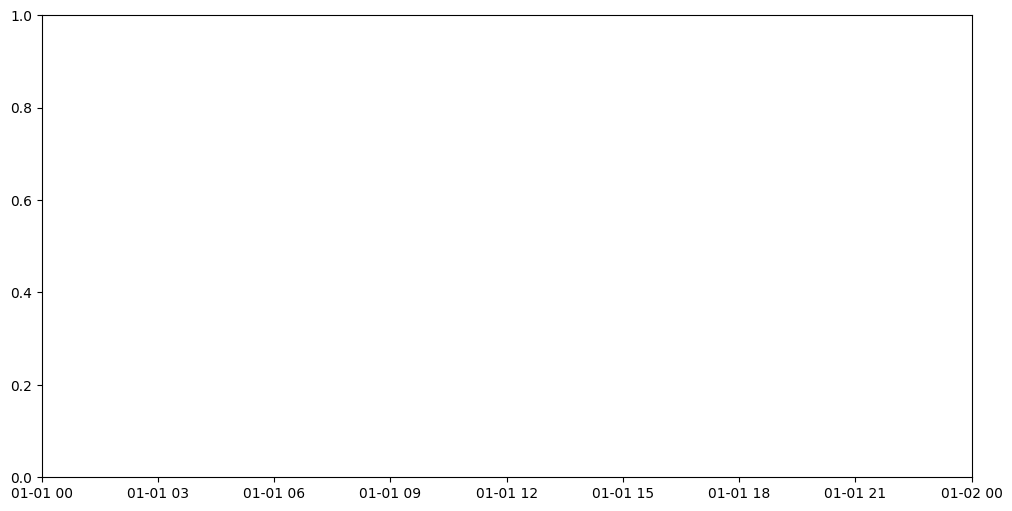

In [ ]:
# Plot results
plt.figure(figsize=(12,6))

plt.plot(test.index[0:100], test, label='Real', color='blue')
plt.plot(test.index[0:100], forecast, label='Forecast', color='red')
plt.xlabel('Datetime')
plt.ylabel('Nat Demand')
plt.title('SARIMA Forecast vs Real')
plt.legend()
plt.tight_layout()
plt.show()